In [1]:
using QuadGK,LaTeXStrings,LinearAlgebra,BenchmarkTools;
using Plots;
import NLsolve,Roots;
pyplot(frame=:box,size=(500,350));

In [27]:
include("./libs/constants.jl");
include("./libs/pwa.jl");
include("./libs/potentials.jl");

In [4]:
function quadgauss(f, x::T, w::T) where {T<:Vector{Float64}}
    res = zero(f(x[1]))  # zero of the same type as f(x[1]), to avoid type instability
    for i in eachindex(x)
        res += f(x[i]) * w[i]
    end
    return res
end

λf(x, y, z) = x^2 + y^2 + z^2 - 2 * x * y - 2 * x * z - 2 * y * z
q0f(E, m1, m2, m3, m4) = abs(m3^2 - m4^2 - m1^2 + m2^2) / (2 * E)
μf(m1, m2) = m1 * m2 / (m1 + m2)

# redefine sqrt so that its cut is along the positive x axis
function xsqrt(x)
    imag(x) >=0 ? sqrt(x+0im) : -sqrt(x-0im)
end
xsqrt1(x)= (imag(x)<0&&real(x)>0) ? -xsqrt(x) : xsqrt(x)

xsqrt1 (generic function with 1 method)

In [13]:
# ----------------------------------------------------------DD*----------------------------------------------------#
function potential_DnDsc(E,p, q; I=0, a=0,a1=0.0, cl=:ss)
    q01, q02 = q0f(E, mDn, mDsc, mDn, mDsc), q0f(E, mDn, mDsc, mDsc, mDn)
    res = zero(ComplexF64)
#     res += -β^2 * gV^2 * (1 - q01^2 / mρn^2) / sqrt(16) * pwa_central(p, q, mρn^2 - q01^2; cl=cl)
#     res += β^2 * gV^2 * (1 - q01^2 / mω^2) / sqrt(16) * pwa_central(p, q, mω^2 - q01^2; cl=cl)
#     res += -4 * gs^2 / sqrt(16) * pwa_central(p, q, mσ^2 - q01^2; cl=cl)
#     res += -4 * g^2 / fπ^2 / sqrt(16) * (pwa_tensor_deform(p, q, mπc^2 - q02^2; cl=cl) - a1 / 3 * pwa_contact(p, q, mπc^2 - q02^2; cl=cl)) * (I - 1 / 2) * 2
#     res += ((2 * sqrt(2) * gV * gλ)^2 / sqrt(16) * (pwa_tensor(p, q, mρc^2 - q02^2; cl=cl) + 2 * a / 3 * pwa_contact(p, q, mρc^2 - q02^2; cl=cl)
#                                                     -
#                                                     pwa_square(p, q, mρc^2 - q02^2; cl=cl)) * (I - 1 / 2) * 2)
    res += -β^2 * gV^2 * (1 - q01^2 / mJψ^2) / sqrt(16) * pwa_central(p, q, mJψ^2 - q01^2; cl=cl) * (-2)
    return res
end

function potential_DcDsn(E,p, q; I=0, a=0,a1=0.0, cl=:ss)
    q01, q02 = q0f(E, mDc, mDsn, mDc, mDsn), q0f(E, mDc, mDsn, mDsn, mDc)
    res = zero(ComplexF64)

#     res += -β^2 * gV^2 * (1 - q01^2 / mρn^2) / sqrt(16) * pwa_central(p, q, mρn^2 - q01^2; cl=cl)
#     res += β^2 * gV^2 * (1 - q01^2 / mω^2) / sqrt(16) * pwa_central(p, q, mω^2 - q01^2; cl=cl)
#     res += -4 * gs^2 / sqrt(16) * pwa_central(p, q, mσ^2 - q01^2; cl=cl)
#     res += -4 * g^2 / fπ^2 / sqrt(16) * (pwa_tensor_deform(p, q, mπc^2 - q02^2; cl=cl) - a1 / 3 * pwa_contact(p, q, mπc^2 - q02^2; cl=cl)) * (I - 1 / 2) * 2
#     res += ((2 * sqrt(2) * gV * gλ)^2 / sqrt(16) * (pwa_tensor(p, q, mρc^2 - q02^2; cl=cl) + 2 * a / 3 * pwa_contact(p, q, mρc^2 - q02^2; cl=cl)
#                                                     -
#                                                     pwa_square(p, q, mρc^2 - q02^2; cl=cl)) * (I - 1 / 2) * 2)
    res += -β^2 * gV^2 * (1 - q01^2 / mJψ^2) / sqrt(16) * pwa_central(p, q, mJψ^2 - q01^2; cl=cl) * (-2)
    return res
end

function potential_DDscross(E,p, q; I=0, a=0,a1=0.0, cl=:ss)
    q01, q02 = q0f(E, mDn, mDsc, mDc, mDsn), q0f(E, mDn, mDsc, mDsn, mDc)
    res = zero(ComplexF64)

    res += 2 * β^2 * gV^2 * (1 - q01^2 / mρc^2) / sqrt(16) * pwa_central(p, q, mρc^2 - q01^2; cl=cl)
#     res += 2 * g^2 / fπ^2 / sqrt(16) * (pwa_tensor_deform(p, q, mπn^2 - q02^2; cl=cl) - a1 / 3 * pwa_contact(p, q, mπn^2 - q02^2; cl=cl)) * (I - 1 / 2) * 2
#     res += -2 * g^2 / (3fπ^2) / sqrt(16) * (pwa_tensor(p, q, mη^2 - q02^2; cl=cl) - a / 3 * pwa_contact(p, q, mη^2 - q02^2; cl=cl)) * (I - 1 / 2) * 2
#     res += (-(2 * gV * gλ)^2 / sqrt(16) * (pwa_tensor(p, q, mρn^2 - q02^2; cl=cl) + 2 * a / 3 * pwa_contact(p, q, mρn^2 - q02^2; cl=cl)
#                                            -
#                                            pwa_square(p, q, mρn^2 - q02^2; cl=cl)) * (I - 1 / 2) * 2)
#     res += ((2 * gV * gλ)^2 / sqrt(16) * (pwa_tensor(p, q, mω^2 - q02^2; cl=cl) + 2 * a / 3 * pwa_contact(p, q, mω^2 - q02^2; cl=cl)
#                                           -
#                                           pwa_square(p, q, mω^2 - q02^2; cl=cl)) * (I - 1 / 2) * 2)
#     #ηc,J/ψ
#     res += 2 * g^2 / fπ^2 / sqrt(16) * (pwa_tensor(p, q, mηc^2 - q02^2; cl=cl) - a / 3 * pwa_contact(p, q, mηc^2 - q02^2; cl=cl)) * (-2) * (I - 1 / 2) * 2
#     res += (-(2 * gV * gλ)^2 / sqrt(16) * (pwa_tensor(p, q, mJψ^2 - q02^2; cl=cl) + 2 * a / 3 * pwa_contact(p, q, mJψ^2 - q02^2; cl=cl)
#                                            -
#                                            pwa_square(p, q, mJψ^2 - q02^2; cl=cl)) * (I - 1 / 2) * 2*(-2))
    return res
end

potential_DDscross (generic function with 1 method)

# width of D^*

In [5]:
function Γf(E,q,m1,m2,m3,m12)
    E1=E+m12-sqrt(m12^2+q^2+0im)-sqrt(m3^2+q^2+0im)
    μ=(m1*m2)/(m1+m2)
    return (imag(E1)<0&&real(E1)>(m1+m2)) ? -xsqrt(2*μ*(E1-m1-m2)+0im) : xsqrt(2*μ*(E1-m1-m2)+0im)
end

function Γf3(E,q,m1,m2,m3,m12)
    E1=E+m12-sqrt(m12^2+q^2+0im)-sqrt(m3^2+q^2+0im)
    μ=(m1*m2)/(m1+m2)
    return (imag(E1)<0&&real(E1)>(m1+m2)) ? -xsqrt(2*μ*(E1-m1-m2)+0im)^3 : xsqrt(2*μ*(E1-m1-m2)+0im)^3
end

function dΓf3(E,q,m1,m2,m3,m12)
    E1=E+m12-sqrt(m12^2+q^2+0im)-sqrt(m3^2+q^2+0im)
    μ=(m1*m2)/(m1+m2)
    tmp=-3*μ*xsqrt(2*μ*(E1-m1-m2)+0im)*(q/sqrt(m12^2+q^2+0im)+q/sqrt(m3^2+q^2+0im))
    return (imag(E1)<0&&real(E1)>(m1+m2)) ? -tmp : tmp
end

ΓDscf(E, p) = (ΓRDsc + g^2 * mDn / (6 * π * fπ^2 * mDsc) * Γf3(E, p, mDn, mπc, mDn,mDsc)
                                   + g^2 * mDc / (12 * π * fπ^2 * mDsc) * Γf3(E, p, mDc, mπn, mDn,mDsc))

ΓDsnf(E, p) = (ΓRDsn + g^2 * mDn / (12 * π * fπ^2 * mDsn) * Γf3(E, p, mDn, mπn, mDc,mDsn)
                                   + g^2 * mDc / (6 * π * fπ^2 * mDsn) * (Γf3(E, p, mDc, mπc, mDc,mDsn) - Γf3(mDc + mDsn, 0, mDc, mπc, mDc,mDsn)))

dΓDscf(E, p) = (g^2 * mDn / (6 * π * fπ^2 * mDsc) * dΓf3(E, p, mDn, mπc, mDn,mDsc)
                                   + g^2 * mDc / (12 * π * fπ^2 * mDsc) * dΓf3(E, p, mDc, mπn, mDn,mDsc))

dΓDsnf(E, p) = (g^2 * mDn / (12 * π * fπ^2 * mDsn) * dΓf3(E, p, mDn, mπn, mDc,mDsn)+ g^2 * mDc / (6 * π * fπ^2 * mDsn) * dΓf3(E, p, mDc, mπc, mDc,mDsn))

function find_singular(E, den; pstart = [0.01, 0.01])
    function f!(F, x)
        pr, pi = x
        tmp = den(E, pr + im * pi)
        F[1] = real(tmp)
        F[2] = imag(tmp)
    end
    sol = NLsolve.nlsolve((F, x) -> f!(F, x), pstart)
    return sol.zero[1] + im * sol.zero[2]
end
qon_c(E)=find_singular(E, (E, p) -> E-mDn-mDsc - p^2 / (2 * μf(mDn, mDsc)) + im * ΓDscf(E, p) / 2; pstart = [reim(xsqrt1(E-mDn-mDsc + im * ΓDsc / 2))...])

qon_0(E)=find_singular(E, (E, p) -> E-mDc-mDsn - p^2 / (2 * μf(mDc, mDsn)) + im * ΓDsnf(E, p) / 2; pstart = [reim(xsqrt1(E-mDc-mDsn + im * ΓDsn / 2))...])


qon_0 (generic function with 1 method)

In [6]:
@btime qon_c(3.874)

  6.944 μs (58 allocations: 4.08 KiB)


0.0009031406050093312 + 0.04613250749939164im

# path deformation

In [8]:
xxx,www=gauss(30,0,1);
xxx3,www3=gauss(30*3,0,1);

qi=zeros(ComplexF64,2+3*length(xxx));
wi=zeros(ComplexF64,3*length(xxx));

function Einner(E,q,m1,m2,m3,m12)
    return E+m12-sqrt(m12^2+q^2+0im)-sqrt(m3^2+q^2+0im)
end

function find_qint(E,m1,m2,m3,m12;rtol=1e-6)
    Etmp=E+m12-m1-m2-im*rtol
    qtmp=sqrt(λf(Etmp^2,m12^2,m3^2))/(2*Etmp)
    return imag(qtmp)>0 ? -qtmp : qtmp
end

function sol_qint3(qint1,qint2)
    a,b=reim(qint1)
    c,d=reim(qint2)
    return b*(c-a)/(b-d)+a
end

function find_qw(E,Λ=0.5;qi=qi,wi=wi,xxx=xxx,www=www,xxx3=xxx3,www3=www3)
    
    # wi is the one wrappered with g'(x)
    qi[1],qi[2]=qon_c(E),qon_0(E)
    if imag(E)>=0||(real(E)<=mDn+mDn+mπc)
        for i in eachindex(xxx3)
            qi[i+2]=Λ*xxx3[i]
            wi[i]=Λ*www3[i]
        end
        return nothing
    end
    
    # find closet DDπ
    qint1,qint2=zeros(ComplexF64,2)
    if real(E)>mDc+mDc+mπc
        qint1=find_qint(E,mDc,mπc,mDc,mDsn)
        qint2=find_qint(E,mDn,mπc,mDn,mDsc)
    elseif real(E)>mDc+mDn+mπn
        qint1=find_qint(E,mDc,mπn,mDn,mDsc)
        qint2=find_qint(E,mDn,mπc,mDn,mDsc)
    else
        qint1=find_qint(E,mDn,mπc,mDn,mDsc)
        qint2=2*real(qint1)
    end
    
    @assert real(qint1)>0&&imag(qint1)<0 "Wrong qint1 position!"
    @assert imag(qint2)>imag(qint1)&&imag(qint2)<=0&&real(qint2)>real(qint1) "Wrong qint2 position!"
    
    qint3=sol_qint3(qint1,qint2)
    len=length(xxx)
    for i in eachindex(xxx)
        qi[2+i]=qint1*xxx[i]
        qi[2+len+i]=qint1+(qint3-qint1)*xxx[i]
        qi[2+2*len+i]=qint3 +(Λ-qint3) *xxx[i]
        wi[i]=qint1*www[i]
        wi[i+len]=(qint3-qint1)*www[i]
        wi[i+2*len]=(Λ-qint3)*www[i]
    end
    return nothing
end

find_qw (generic function with 2 methods)

In [9]:
find_qw(mDn+mDsc-360e-6-im*24e-6,0.5)

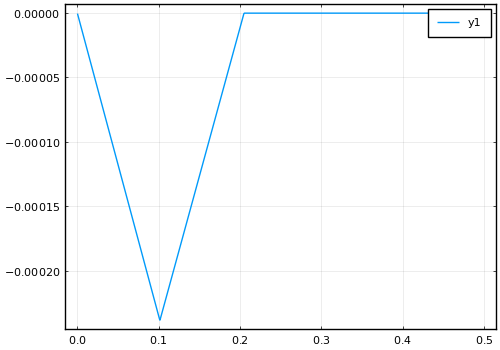

In [10]:
plot(real.(qi[3:end]),imag.(qi[3:end]))

# VGT

In [11]:
Vmat=zeros(ComplexF64,4*(2+3*length(xxx)),4*(2+3*length(xxx)));
Gmat=zeros(ComplexF64,4*(2+3*length(xxx)),4*(2+3*length(xxx)));
Tmat=zeros(ComplexF64,4*(2+3*length(xxx)),4*(2+3*length(xxx)));

In [14]:
function VMat!(E;a = 0.0,a1=0.0,Λ=0.5,I=0,plist=qi,des=Vmat)
    find_qw(E,Λ)
    sublen=length(plist)

    for l in eachindex(plist)
        for m in eachindex(plist)
            i, j = 1, 1
            des[sublen*(i-1)+l, sublen*(j-1)+m] = (potential_DnDsc(E,plist[l], plist[m]; a = a,a1=a1,I=I, cl = :ss))
            i, j = 1, 2
            des[sublen*(i-1)+l, sublen*(j-1)+m] = (potential_DnDsc(E,plist[l], plist[m]; a = a,a1=a1,I=I, cl = :ds))
            i, j = 2, 1
            des[sublen*(i-1)+l, sublen*(j-1)+m] = (potential_DnDsc(E,plist[l], plist[m]; a = a,a1=a1,I=I,  cl = :sd))
            i, j = 2, 2
            des[sublen*(i-1)+l, sublen*(j-1)+m] = (potential_DnDsc(E,plist[l], plist[m]; a = a,a1=a1,I=I, cl = :dd))
            i, j = 1, 3
            des[sublen*(i-1)+l, sublen*(j-1)+m] = (potential_DDscross(E,plist[l], plist[m]; a = a,a1=a1,I=I,  cl = :ss))
            i, j = 1, 4
            des[sublen*(i-1)+l, sublen*(j-1)+m] = (potential_DDscross(E,plist[l], plist[m]; a = a,a1=a1,I=I,  cl = :ds))
            i, j = 2, 3
            des[sublen*(i-1)+l, sublen*(j-1)+m] = (potential_DDscross(E,plist[l], plist[m]; a = a,a1=a1,I=I,  cl = :sd))
            i, j = 2, 4
            des[sublen*(i-1)+l, sublen*(j-1)+m] = (potential_DDscross(E,plist[l], plist[m]; a = a,a1=a1,I=I,  cl = :dd))
            i, j = 3, 1
            des[sublen*(i-1)+l, sublen*(j-1)+m] = (potential_DDscross(E,plist[l], plist[m]; a = a,a1=a1,I=I,  cl = :ss))
            i, j = 3, 2
            des[sublen*(i-1)+l, sublen*(j-1)+m] = (potential_DDscross(E,plist[l], plist[m]; a = a,a1=a1,I=I,  cl = :ds))
            i, j = 4, 1
            des[sublen*(i-1)+l, sublen*(j-1)+m] = (potential_DDscross(E,plist[l], plist[m]; a = a,a1=a1,I=I,  cl = :sd))
            i, j = 4, 2
            des[sublen*(i-1)+l, sublen*(j-1)+m] = (potential_DDscross(E,plist[l], plist[m]; a = a,a1=a1,I=I,  cl = :dd))
            i, j = 3, 3
            des[sublen*(i-1)+l, sublen*(j-1)+m] = (potential_DcDsn(E,plist[l], plist[m]; a = a,a1=a1,I=I,  cl = :ss))
            i, j = 3, 4
            des[sublen*(i-1)+l, sublen*(j-1)+m] = (potential_DcDsn(E,plist[l], plist[m]; a = a,a1=a1,I=I,  cl = :ds))
            i, j = 4, 3
            des[sublen*(i-1)+l, sublen*(j-1)+m] = (potential_DcDsn(E,plist[l], plist[m]; a = a,a1=a1,I=I,  cl = :sd))
            i, j = 4, 4
            des[sublen*(i-1)+l, sublen*(j-1)+m] = (potential_DcDsn(E,plist[l], plist[m]; a = a,a1=a1,I=I,  cl = :dd))
        end
    end
    return nothing
end

VMat! (generic function with 1 method)

In [15]:
@btime VMat!(mDn+mDsc-360e-6-im*24e-6)

  1.668 s (12228052 allocations: 576.18 MiB)


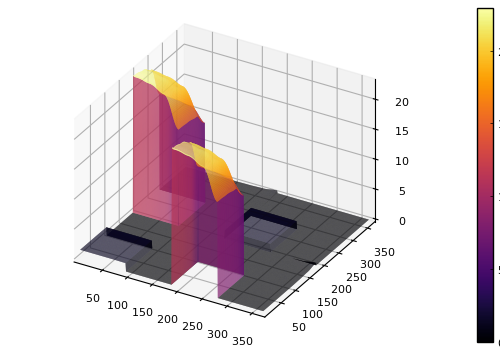

In [16]:
surface(collect(1:4*length(qi)),collect(1:4*length(qi)),[real(Vmat[x,y]) for y in 1:4*length(qi),x in 1:4*length(qi)])

In [17]:
Gc(E,q)=1/(2π^2)/(E-mDn-mDsc-q^2/(2*μf(mDn,mDsc))+im*ΓDscf(E,q)/2)
Gn(E,q)=1/(2π^2)/(E-mDc-mDsn-q^2/(2*μf(mDc,mDsn))+im*ΓDsnf(E,q)/2)

Gn (generic function with 1 method)

In [18]:
function GMat!(E;qi=qi,wi=wi,Λ=0.5,des=Gmat)
    find_qw(E,Λ)
    sublen=length(qi)
    μ1,μ2=μf(mDn,mDsc),μf(mDc,mDsn)
    k1,k2=qi[1],qi[2]
    
    for i in 1:2
        for j in eachindex(wi)
            des[(i-1)*sublen+2+j,(i-1)*sublen+2+j]=wi[j]*qi[2+j]^2*Gc(E,qi[2+j])
        end
    end
    
    for i in 3:4
        for j in eachindex(wi)
            des[(i-1)*sublen+2+j,(i-1)*sublen+2+j]=wi[j]*qi[2+j]^2*Gn(E,qi[2+j])
        end
    end
    
    return nothing
end

GMat! (generic function with 1 method)

In [19]:
function detVG(E;a = 0.0,a1=0.0,Λ=0.5,I=0)
    VMat!(E;a=a,a1=a1,Λ=Λ,I=I)
    GMat!(E;Λ=Λ)
    return det(LinearAlgebra.I-Vmat*Gmat)
end

detVG (generic function with 1 method)

In [20]:
function TMat!(E;a = 0.0,a1=0.0,Λ=0.5,I=0,des=Tmat)
    VMat!(E;a=a,a1=a1,Λ=Λ,I=I)
    GMat!(E;Λ=Λ)
    des .=inv(LinearAlgebra.I-Vmat*Gmat)*Vmat
    return nothing
end

TMat! (generic function with 1 method)

# parameters study

In [21]:
using Optim;

In [22]:
function inv_abst(x;E=mDn+mDsc-273e-6,I=0)
    TMat!(E;a=x[1],a1=0.0,Λ=x[2],I=I)
    return 1/abs(Tmat[1,1])
end

inv_abst (generic function with 1 method)

In [23]:
function absdet(x;E=mDn+mDsc-360e-6-im*24e-6,I=0)
    abs(detVG(E;a=x[1],a1=0.0,Λ=x[2],I=I))
end

absdet (generic function with 1 method)

## test1:only direct rho&jpsi

In [31]:
# ----------------------------------------------------------DD*----------------------------------------------------#
function potential_DnDsc(E,p, q; I=0, a=0,a1=0.0, cl=:ss)
    q01, q02 = q0f(E, mDn, mDsc, mDn, mDsc), q0f(E, mDn, mDsc, mDsc, mDn)
    res = zero(ComplexF64)
    res += -β^2 * gV^2 * (1 - q01^2 / mJψ^2) / sqrt(16) * pwa_central(p, q, mJψ^2 - q01^2; cl=cl) * (-2)
    return res
end

function potential_DcDsn(E,p, q; I=0, a=0,a1=0.0, cl=:ss)
    q01, q02 = q0f(E, mDc, mDsn, mDc, mDsn), q0f(E, mDc, mDsn, mDsn, mDc)
    res = zero(ComplexF64)
    res += -β^2 * gV^2 * (1 - q01^2 / mJψ^2) / sqrt(16) * pwa_central(p, q, mJψ^2 - q01^2; cl=cl) * (-2)
    return res
end

function potential_DDscross(E,p, q; I=0, a=0,a1=0.0, cl=:ss)
    q01, q02 = q0f(E, mDn, mDsc, mDc, mDsn), q0f(E, mDn, mDsc, mDsn, mDc)
    res = zero(ComplexF64)

    res += 2 * β^2 * gV^2 * (1 - q01^2 / mρc^2) / sqrt(16) * pwa_central(p, q, mρc^2 - q01^2; cl=cl)
    return res
end

potential_DDscross (generic function with 1 method)

In [24]:
let 
    tmpf(x)=inv_abst([0.0,x[1]])
    init_val=[0.5]
    lower=[0.3]
    upper=[1.0]
    res=Optim.optimize(tmpf,lower,upper,init_val)
    println(Optim.minimum(res))
    println(Optim.minimizer(res))
end

0.0001657225285840902
[0.8263100993481041]


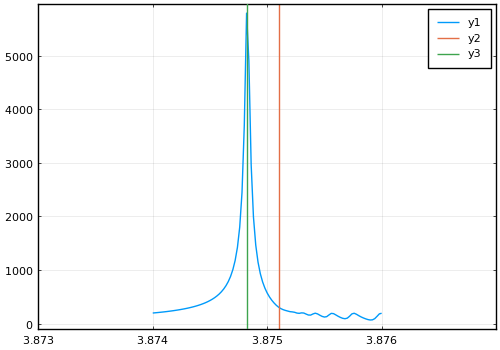

In [32]:
let Ev=collect(3.874:0.00002:3.876)
    function tmpf(E)
        TMat!(E;a=0.0,Λ=0.8263100993481041,I=0)
        abs(Tmat[1,1])
    end
    resv=[tmpf(e) for e in Ev]
    plot(Ev,resv,xlims=(3.873,3.877))
    vline!([mDn+mDsc])
    vline!([mDn+mDsc-273e-6])
end

## test2: only direct rho&jpsi&rho1450

In [28]:
# ----------------------------------------------------------DD*----------------------------------------------------#
function potential_DnDsc(E,p, q; I=0, a=0,a1=0.0, cl=:ss)
    q01, q02 = q0f(E, mDn, mDsc, mDn, mDsc), q0f(E, mDn, mDsc, mDsc, mDn)
    res = zero(ComplexF64)
    res += -β^2 * gV^2 * (1 - q01^2 / mJψ^2) / sqrt(16) * pwa_central(p, q, mJψ^2 - q01^2; cl=cl) * (-2)
    return res
end

function potential_DcDsn(E,p, q; I=0, a=0,a1=0.0, cl=:ss)
    q01, q02 = q0f(E, mDc, mDsn, mDc, mDsn), q0f(E, mDc, mDsn, mDsn, mDc)
    res = zero(ComplexF64)
    res += -β^2 * gV^2 * (1 - q01^2 / mJψ^2) / sqrt(16) * pwa_central(p, q, mJψ^2 - q01^2; cl=cl) * (-2)
    return res
end

function potential_DDscross(E,p, q; I=0, a=0,a1=0.0, cl=:ss)
    q01, q02 = q0f(E, mDn, mDsc, mDc, mDsn), q0f(E, mDn, mDsc, mDsn, mDc)
    res = zero(ComplexF64)

    res += 2 * β^2 * gV^2 * (1 - q01^2 / mρc^2) / sqrt(16) * pwa_central(p, q, mρc^2 - q01^2; cl=cl)
    res += 2 * β^2 * gV^2 * (1 - q01^2 / mρ1450^2) / sqrt(16) * pwa_central(p, q, mρ1450^2 - q01^2; cl=cl)
    return res
end

potential_DDscross (generic function with 1 method)

In [29]:
let 
    tmpf(x)=inv_abst([0.0,x[1]])
    init_val=[0.5]
    lower=[0.3]
    upper=[1.0]
    res=Optim.optimize(tmpf,lower,upper,init_val)
    println(Optim.minimum(res))
    println(Optim.minimizer(res))
end

0.00016575865297785032
[0.5088220507569198]


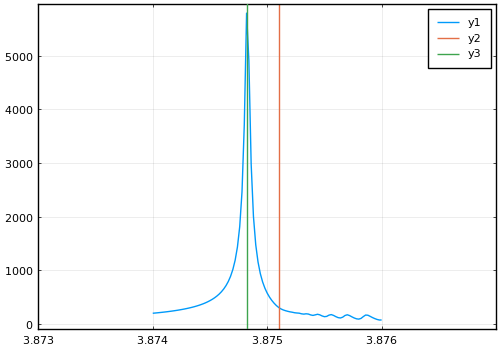

In [30]:
let Ev=collect(3.874:0.00002:3.876)
    function tmpf(E)
        TMat!(E;a=0.0,Λ=0.5088220507569198,I=0)
        abs(Tmat[1,1])
    end
    resv=[tmpf(e) for e in Ev]
    plot(Ev,resv,xlims=(3.873,3.877))
    vline!([mDn+mDsc])
    vline!([mDn+mDsc-273e-6])
end

## test3:short-distance

In [35]:
function potential_DnDsc(E,p, q; I=0, a=0,a1=0.0, cl=:ss)
    q01, q02 = q0f(E, mDn, mDsc, mDn, mDsc), q0f(E, mDn, mDsc, mDsc, mDn)
    res = zero(ComplexF64)
#     res += -β^2 * gV^2 * (1 - q01^2 / mρn^2) / sqrt(16) * pwa_central(p, q, mρn^2 - q01^2; cl=cl)
#     res += β^2 * gV^2 * (1 - q01^2 / mω^2) / sqrt(16) * pwa_central(p, q, mω^2 - q01^2; cl=cl)
    res += -4 * gs^2 / sqrt(16) * pwa_central(p, q, mσ^2 - q01^2; cl=cl)
#     res += -4 * g^2 / fπ^2 / sqrt(16) * (pwa_tensor_deform(p, q, mπc^2 - q02^2; cl=cl) - a1 / 3 * pwa_contact(p, q, mπc^2 - q02^2; cl=cl)) * (I - 1 / 2) * 2
#     res += ((2 * sqrt(2) * gV * gλ)^2 / sqrt(16) * (pwa_tensor(p, q, mρc^2 - q02^2; cl=cl) + 2 * a / 3 * pwa_contact(p, q, mρc^2 - q02^2; cl=cl)
#                                                     -
#                                                     pwa_square(p, q, mρc^2 - q02^2; cl=cl)) * (I - 1 / 2) * 2)
    res += -β^2 * gV^2 * (1 - q01^2 / mJψ^2) / sqrt(16) * pwa_central(p, q, mJψ^2 - q01^2; cl=cl) * (-2)
    return res
end

function potential_DcDsn(E,p, q; I=0, a=0,a1=0.0, cl=:ss)
    q01, q02 = q0f(E, mDc, mDsn, mDc, mDsn), q0f(E, mDc, mDsn, mDsn, mDc)
    res = zero(ComplexF64)

#     res += -β^2 * gV^2 * (1 - q01^2 / mρn^2) / sqrt(16) * pwa_central(p, q, mρn^2 - q01^2; cl=cl)
#     res += β^2 * gV^2 * (1 - q01^2 / mω^2) / sqrt(16) * pwa_central(p, q, mω^2 - q01^2; cl=cl)
    res += -4 * gs^2 / sqrt(16) * pwa_central(p, q, mσ^2 - q01^2; cl=cl)
#     res += -4 * g^2 / fπ^2 / sqrt(16) * (pwa_tensor_deform(p, q, mπc^2 - q02^2; cl=cl) - a1 / 3 * pwa_contact(p, q, mπc^2 - q02^2; cl=cl)) * (I - 1 / 2) * 2
#     res += ((2 * sqrt(2) * gV * gλ)^2 / sqrt(16) * (pwa_tensor(p, q, mρc^2 - q02^2; cl=cl) + 2 * a / 3 * pwa_contact(p, q, mρc^2 - q02^2; cl=cl)
#                                                     -
#                                                     pwa_square(p, q, mρc^2 - q02^2; cl=cl)) * (I - 1 / 2) * 2)
    res += -β^2 * gV^2 * (1 - q01^2 / mJψ^2) / sqrt(16) * pwa_central(p, q, mJψ^2 - q01^2; cl=cl) * (-2)
    return res
end

function potential_DDscross(E,p, q; I=0, a=0,a1=0.0, cl=:ss)
    q01, q02 = q0f(E, mDn, mDsc, mDc, mDsn), q0f(E, mDn, mDsc, mDsn, mDc)
    res = zero(ComplexF64)

    res += 2 * β^2 * gV^2 * (1 - q01^2 / mρc^2) / sqrt(16) * pwa_central(p, q, mρc^2 - q01^2; cl=cl)
#     res += 2 * g^2 / fπ^2 / sqrt(16) * (pwa_tensor_deform(p, q, mπn^2 - q02^2; cl=cl) - a1 / 3 * pwa_contact(p, q, mπn^2 - q02^2; cl=cl)) * (I - 1 / 2) * 2
#     res += -2 * g^2 / (3fπ^2) / sqrt(16) * (pwa_tensor(p, q, mη^2 - q02^2; cl=cl) - a / 3 * pwa_contact(p, q, mη^2 - q02^2; cl=cl)) * (I - 1 / 2) * 2
#     res += (-(2 * gV * gλ)^2 / sqrt(16) * (pwa_tensor(p, q, mρn^2 - q02^2; cl=cl) + 2 * a / 3 * pwa_contact(p, q, mρn^2 - q02^2; cl=cl)
#                                            -
#                                            pwa_square(p, q, mρn^2 - q02^2; cl=cl)) * (I - 1 / 2) * 2)
#     res += ((2 * gV * gλ)^2 / sqrt(16) * (pwa_tensor(p, q, mω^2 - q02^2; cl=cl) + 2 * a / 3 * pwa_contact(p, q, mω^2 - q02^2; cl=cl)
#                                           -
#                                           pwa_square(p, q, mω^2 - q02^2; cl=cl)) * (I - 1 / 2) * 2)
#     #ηc,J/ψ
#     res += 2 * g^2 / fπ^2 / sqrt(16) * (pwa_tensor(p, q, mηc^2 - q02^2; cl=cl) - a / 3 * pwa_contact(p, q, mηc^2 - q02^2; cl=cl)) * (-2) * (I - 1 / 2) * 2
#     res += (-(2 * gV * gλ)^2 / sqrt(16) * (pwa_tensor(p, q, mJψ^2 - q02^2; cl=cl) + 2 * a / 3 * pwa_contact(p, q, mJψ^2 - q02^2; cl=cl)
#                                            -
#                                            pwa_square(p, q, mJψ^2 - q02^2; cl=cl)) * (I - 1 / 2) * 2*(-2))
    return res
end

potential_DDscross (generic function with 1 method)

In [36]:
let 
    tmpf(x)=inv_abst([0.0,x[1]])
    init_val=[0.5]
    lower=[0.3]
    upper=[1.0]
    res=Optim.optimize(tmpf,lower,upper,init_val)
    println(Optim.minimum(res))
    println(Optim.minimizer(res))
end

0.00016538044743675268
[0.7300117538872736]


## full with rho1450

In [60]:
function potential_DnDsc(E,p, q; I=0, a=0,a1=0.0, cl=:ss)
    q01, q02 = q0f(E, mDn, mDsc, mDn, mDsc), q0f(E, mDn, mDsc, mDsc, mDn)
    res = zero(ComplexF64)
    res += -β^2 * gV^2 * (1 - q01^2 / mρn^2) / sqrt(16) * pwa_central(p, q, mρn^2 - q01^2; cl=cl)
    res += β^2 * gV^2 * (1 - q01^2 / mω^2) / sqrt(16) * pwa_central(p, q, mω^2 - q01^2; cl=cl)
    res += -4 * gs^2 / sqrt(16) * pwa_central(p, q, mσ^2 - q01^2; cl=cl)
    res += -4 * g^2 / fπ^2 / sqrt(16) * (pwa_tensor_deform(p, q, mπc^2 - q02^2; cl=cl) - a1 / 3 * pwa_contact(p, q, mπc^2 - q02^2; cl=cl)) * (I - 1 / 2) * 2
    res += ((2 * sqrt(2) * gV * gλ)^2 / sqrt(16) * (pwa_tensor(p, q, mρc^2 - q02^2; cl=cl) + 2 * a / 3 * pwa_contact(p, q, mρc^2 - q02^2; cl=cl)
                                                    -
                                                    pwa_square(p, q, mρc^2 - q02^2; cl=cl)) * (I - 1 / 2) * 2)
    res += -β^2 * gV^2 * (1 - q01^2 / mJψ^2) / sqrt(16) * pwa_central(p, q, mJψ^2 - q01^2; cl=cl) * (-2)
    return res
end

function potential_DcDsn(E,p, q; I=0, a=0,a1=0.0, cl=:ss)
    q01, q02 = q0f(E, mDc, mDsn, mDc, mDsn), q0f(E, mDc, mDsn, mDsn, mDc)
    res = zero(ComplexF64)

    res += -β^2 * gV^2 * (1 - q01^2 / mρn^2) / sqrt(16) * pwa_central(p, q, mρn^2 - q01^2; cl=cl)
    res += β^2 * gV^2 * (1 - q01^2 / mω^2) / sqrt(16) * pwa_central(p, q, mω^2 - q01^2; cl=cl)
    res += -4 * gs^2 / sqrt(16) * pwa_central(p, q, mσ^2 - q01^2; cl=cl)
    res += -4 * g^2 / fπ^2 / sqrt(16) * (pwa_tensor_deform(p, q, mπc^2 - q02^2; cl=cl) - a1 / 3 * pwa_contact(p, q, mπc^2 - q02^2; cl=cl)) * (I - 1 / 2) * 2
    res += ((2 * sqrt(2) * gV * gλ)^2 / sqrt(16) * (pwa_tensor(p, q, mρc^2 - q02^2; cl=cl) + 2 * a / 3 * pwa_contact(p, q, mρc^2 - q02^2; cl=cl)
                                                    -
                                                    pwa_square(p, q, mρc^2 - q02^2; cl=cl)) * (I - 1 / 2) * 2)
    res += -β^2 * gV^2 * (1 - q01^2 / mJψ^2) / sqrt(16) * pwa_central(p, q, mJψ^2 - q01^2; cl=cl) * (-2)
    return res
end

function potential_DDscross(E,p, q; I=0, a=0,a1=0.0, cl=:ss)
    q01, q02 = q0f(E, mDn, mDsc, mDc, mDsn), q0f(E, mDn, mDsc, mDsn, mDc)
    res = zero(ComplexF64)

    res += 2 * β^2 * gV^2 * (1 - q01^2 / mρc^2) / sqrt(16) * pwa_central(p, q, mρc^2 - q01^2; cl=cl)
    res += 2 * g^2 / fπ^2 / sqrt(16) * (pwa_tensor_deform(p, q, mπn^2 - q02^2; cl=cl) - a1 / 3 * pwa_contact(p, q, mπn^2 - q02^2; cl=cl)) * (I - 1 / 2) * 2
    res += -2 * g^2 / (3fπ^2) / sqrt(16) * (pwa_tensor(p, q, mη^2 - q02^2; cl=cl) - a / 3 * pwa_contact(p, q, mη^2 - q02^2; cl=cl)) * (I - 1 / 2) * 2
    res += (-(2 * gV * gλ)^2 / sqrt(16) * (pwa_tensor(p, q, mρn^2 - q02^2; cl=cl) + 2 * a / 3 * pwa_contact(p, q, mρn^2 - q02^2; cl=cl)
                                           -
                                           pwa_square(p, q, mρn^2 - q02^2; cl=cl)) * (I - 1 / 2) * 2)
    res += ((2 * gV * gλ)^2 / sqrt(16) * (pwa_tensor(p, q, mω^2 - q02^2; cl=cl) + 2 * a / 3 * pwa_contact(p, q, mω^2 - q02^2; cl=cl)
                                          -
                                          pwa_square(p, q, mω^2 - q02^2; cl=cl)) * (I - 1 / 2) * 2)
    #ηc,J/ψ
    res += 2 * g^2 / fπ^2 / sqrt(16) * (pwa_tensor(p, q, mηc^2 - q02^2; cl=cl) - a / 3 * pwa_contact(p, q, mηc^2 - q02^2; cl=cl)) * (-2) * (I - 1 / 2) * 2
    res += (-(2 * gV * gλ)^2 / sqrt(16) * (pwa_tensor(p, q, mJψ^2 - q02^2; cl=cl) + 2 * a / 3 * pwa_contact(p, q, mJψ^2 - q02^2; cl=cl)
                                           -
                                           pwa_square(p, q, mJψ^2 - q02^2; cl=cl)) * (I - 1 / 2) * 2*(-2))
    res += 2 * β^2 * gV^2 * (1 - q01^2 / mρ1450^2) / sqrt(16) * pwa_central(p, q, mρ1450^2 - q01^2; cl=cl)
    return res
end

potential_DDscross (generic function with 1 method)

In [68]:
let 
    tmpf(x)=inv_abst([0.0,x[1]])
    init_val=[0.5]
    lower=[0.3]
    upper=[1.0]
    res=Optim.optimize(tmpf,lower,upper,init_val)
    println(Optim.minimum(res))
    println(Optim.minimizer(res))
end

# Test

In [63]:
function potential_DnDsc(E,p, q; I=0, a=0,a1=1.0, cl=:ss)
    q01, q02 = q0f(E, mDn, mDsc, mDn, mDsc), q0f(E, mDn, mDsc, mDsc, mDn)
    res = zero(ComplexF64)
#     res += -β^2 * gV^2 * (1 - q01^2 / mρn^2) / sqrt(16) * pwa_central(p, q, mρn^2 - q01^2; cl=cl)
#     res += β^2 * gV^2 * (1 - q01^2 / mω^2) / sqrt(16) * pwa_central(p, q, mω^2 - q01^2; cl=cl)
#     res += -4 * gs^2 / sqrt(16) * pwa_central(p, q, mσ^2 - q01^2; cl=cl)
#     res += -4 * g^2 / fπ^2 / sqrt(16) * (pwa_tensor_deform(p, q, mπc^2 - q02^2; cl=cl) - a1 / 3 * pwa_contact(p, q, mπc^2 - q02^2; cl=cl)) * (I - 1 / 2) * 2
#      res += -4 * g^2 / fπ^2 / sqrt(16) * (-(mπc^2 - q02^2)/3)*pwa_central(p, q, mπc^2 - q02^2; cl=cl) * (I - 1 / 2) * 2
    res += ((2 * sqrt(2) * gV * gλ)^2 / sqrt(16) * (pwa_tensor(p, q, mρc^2 - q02^2; cl=cl) + 2 * a / 3 * pwa_contact(p, q, mρc^2 - q02^2; cl=cl)
                                                    -
                                                    pwa_square(p, q, mρc^2 - q02^2; cl=cl)) * (I - 1 / 2) * 2)
#     res += -β^2 * gV^2 * (1 - q01^2 / mJψ^2) / sqrt(16) * pwa_central(p, q, mJψ^2 - q01^2; cl=cl) * (-2)
    return res
end

function potential_DcDsn(E,p, q; I=0, a=0,a1=0.0, cl=:ss)
    q01, q02 = q0f(E, mDc, mDsn, mDc, mDsn), q0f(E, mDc, mDsn, mDsn, mDc)
    res = zero(ComplexF64)

#     res += -β^2 * gV^2 * (1 - q01^2 / mρn^2) / sqrt(16) * pwa_central(p, q, mρn^2 - q01^2; cl=cl)
#     res += β^2 * gV^2 * (1 - q01^2 / mω^2) / sqrt(16) * pwa_central(p, q, mω^2 - q01^2; cl=cl)
#     res += -4 * gs^2 / sqrt(16) * pwa_central(p, q, mσ^2 - q01^2; cl=cl)
#     res += -4 * g^2 / fπ^2 / sqrt(16) * (pwa_tensor_deform(p, q, mπc^2 - q02^2; cl=cl) - a1 / 3 * pwa_contact(p, q, mπc^2 - q02^2; cl=cl)) * (I - 1 / 2) * 2
    res += ((2 * sqrt(2) * gV * gλ)^2 / sqrt(16) * (pwa_tensor(p, q, mρc^2 - q02^2; cl=cl) + 2 * a / 3 * pwa_contact(p, q, mρc^2 - q02^2; cl=cl)
                                                    -
                                                    pwa_square(p, q, mρc^2 - q02^2; cl=cl)) * (I - 1 / 2) * 2)
    res += -β^2 * gV^2 * (1 - q01^2 / mJψ^2) / sqrt(16) * pwa_central(p, q, mJψ^2 - q01^2; cl=cl) * (-2)
    return res
end

function potential_DDscross(E,p, q; I=0, a=0,a1=0.0, cl=:ss)
    q01, q02 = q0f(E, mDn, mDsc, mDc, mDsn), q0f(E, mDn, mDsc, mDsn, mDc)
    res = zero(ComplexF64)

    res += 2 * β^2 * gV^2 * (1 - q01^2 / mρc^2) / sqrt(16) * pwa_central(p, q, mρc^2 - q01^2; cl=cl)
#     res += 2 * g^2 / fπ^2 / sqrt(16) * (pwa_tensor_deform(p, q, mπn^2 - q02^2; cl=cl) - a1 / 3 * pwa_contact(p, q, mπn^2 - q02^2; cl=cl)) * (I - 1 / 2) * 2
#     res += -2 * g^2 / (3fπ^2) / sqrt(16) * (pwa_tensor(p, q, mη^2 - q02^2; cl=cl) - a / 3 * pwa_contact(p, q, mη^2 - q02^2; cl=cl)) * (I - 1 / 2) * 2
#     res += (-(2 * gV * gλ)^2 / sqrt(16) * (pwa_tensor(p, q, mρn^2 - q02^2; cl=cl) + 2 * a / 3 * pwa_contact(p, q, mρn^2 - q02^2; cl=cl)
#                                            -
#                                            pwa_square(p, q, mρn^2 - q02^2; cl=cl)) * (I - 1 / 2) * 2)
#     res += ((2 * gV * gλ)^2 / sqrt(16) * (pwa_tensor(p, q, mω^2 - q02^2; cl=cl) + 2 * a / 3 * pwa_contact(p, q, mω^2 - q02^2; cl=cl)
#                                           -
#                                           pwa_square(p, q, mω^2 - q02^2; cl=cl)) * (I - 1 / 2) * 2)
#     #ηc,J/ψ
#     res += 2 * g^2 / fπ^2 / sqrt(16) * (pwa_tensor(p, q, mηc^2 - q02^2; cl=cl) - a / 3 * pwa_contact(p, q, mηc^2 - q02^2; cl=cl)) * (-2) * (I - 1 / 2) * 2
#     res += (-(2 * gV * gλ)^2 / sqrt(16) * (pwa_tensor(p, q, mJψ^2 - q02^2; cl=cl) + 2 * a / 3 * pwa_contact(p, q, mJψ^2 - q02^2; cl=cl)
#                                            -
#                                            pwa_square(p, q, mJψ^2 - q02^2; cl=cl)) * (I - 1 / 2) * 2*(-2))
    return res
end

potential_DDscross (generic function with 1 method)

In [64]:
VMat!(mDn+mDsc-360e-6-im*24e-6)

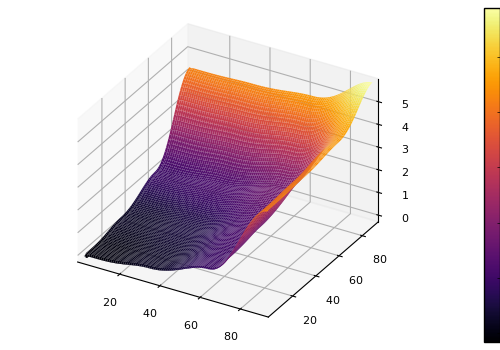

In [65]:
surface(collect(1:length(qi)),collect(1:length(qi)),[real(Vmat[x,y]) for y in 1:length(qi),x in 1:length(qi)])

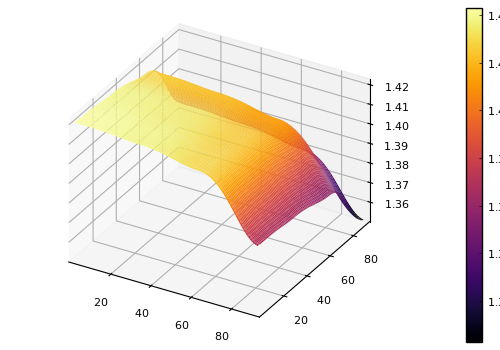

In [46]:
surface(collect(1:length(qi)),collect(1:length(qi)),[real(Vmat[x,y]) for y in 1:length(qi),x in 1:length(qi)])

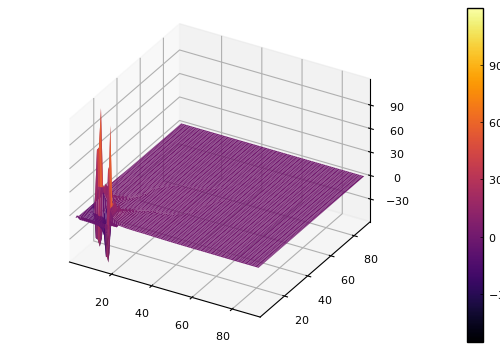

In [58]:
surface(collect(1:length(qi)),collect(1:length(qi)),[real(Vmat[x,y]) for y in 1:length(qi),x in 1:length(qi)])

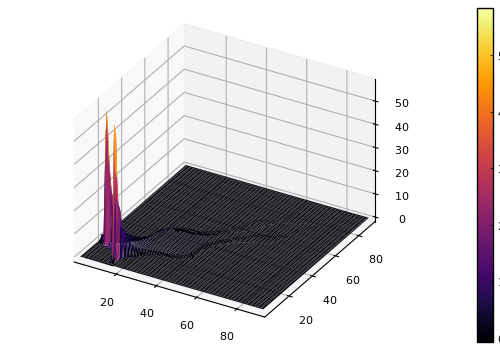

In [59]:
surface(collect(1:length(qi)),collect(1:length(qi)),[imag(Vmat[x,y]) for y in 1:length(qi),x in 1:length(qi)])

In [69]:
function testfunc1(E,p, q; I=0, a=0,a1=1.0, cl=:ss)
    q01, q02 = q0f(E, mDn, mDsc, mDn, mDsc), q0f(E, mDn, mDsc, mDsc, mDn)
    res = zero(ComplexF64)
    res += ((2 * sqrt(2) * gV * gλ)^2 / sqrt(16) * (pwa_tensor(p, q, mρc^2 - q02^2; cl=cl) + 2 * a / 3 * pwa_contact(p, q, mρc^2 - q02^2; cl=cl)
                                                    -
                                                    pwa_square(p, q, mρc^2 - q02^2; cl=cl)) * (I - 1 / 2) * 2)
    return res
end
function testfunc2(E,p, q; I=0, a=0,a1=1.0, cl=:ss)
    q01, q02 = q0f(E, mDn, mDsc, mDn, mDsc), q0f(E, mDn, mDsc, mDsc, mDn)
    res = zero(ComplexF64)
    res += -β^2 * gV^2 * (1 - q01^2 / mJψ^2) / sqrt(16) * pwa_central(p, q, mJψ^2 - q01^2; cl=cl) * (-2)
    return res
end

testfunc2 (generic function with 1 method)

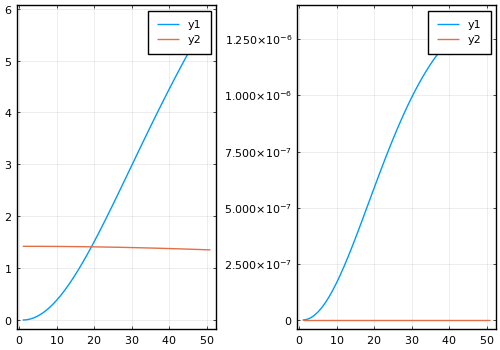

In [71]:
let pv=collect(0.0:0.01:0.5)
    resv1=[testfunc1(mDn+mDsc-360e-6-im*24e-6,p, p) for p in pv]
    resv2=[testfunc2(mDn+mDsc-360e-6-im*24e-6,p, p) for p in pv]
    p1=plot(real.(resv1))
    plot!(real.(resv2))
    p2=plot(imag.(resv1))
    plot!(imag.(resv2))
    plot(p1,p2)
end

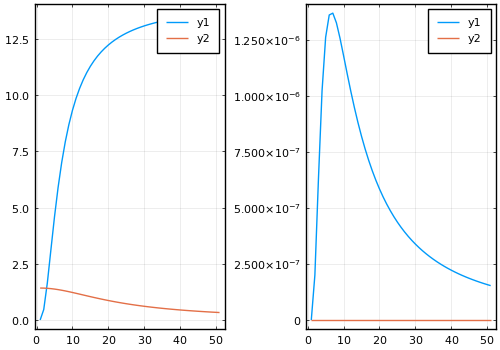

In [72]:
let pv=collect(0.0:0.1:5)
    resv1=[testfunc1(mDn+mDsc-360e-6-im*24e-6,p, p) for p in pv]
    resv2=[testfunc2(mDn+mDsc-360e-6-im*24e-6,p, p) for p in pv]
    p1=plot(real.(resv1))
    plot!(real.(resv2))
    p2=plot(imag.(resv1))
    plot!(imag.(resv2))
    plot(p1,p2)
end